https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

Problem Description:
We aim to perform unsupervised learning to analyze and group individuals based on their eating habits 
and physical conditions. This dataset contains demographic, dietary, and activity-based attributes 
collected from individuals in Colombia, Mexico, and Peru. 

The goal:
1. Use clustering techniques (KMeans, DBSCAN) to identify distinct groups of individuals.
2. Analyze the characteristics of each group using descriptive statistics and visualization.
3. Optionally compare discovered clusters with the target variable `NObeyesdad` for interpretation.

In [1]:
# Step 1: Import Necessary Libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Define the path to the ZIP file
zip_file_path = 'estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip'
extract_dir = 'obesity_dataset'

In [3]:
# Extract ZIP file contents
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to '{extract_dir}' directory.")

Files extracted to 'obesity_dataset' directory.


In [4]:
# List extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted Files:")
print(extracted_files)


Extracted Files:
['ObesityDataSet_raw_and_data_sinthetic.csv']


# LOAD DATA


In [5]:
# Load the dataset into a DataFrame
csv_file_path = os.path.join(extract_dir, 'ObesityDataSet_raw_and_data_sinthetic.csv')
df = pd.read_csv(csv_file_path)

In [6]:
# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2 

The data is clean with no missing values displayed.
It includes both numerical and categorical variables.
The target column NObeyesdad classifies individuals into weight categories (e.g., "Normal_Weight", "Overweight_Level_I").



# EXPLORATORY DATA ANALYSIS (EDA)

In [7]:
# Basic dataset information
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF         

In [8]:
# Summary statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))


Summary Statistics:
       Gender          Age       Height       Weight  \
count    2111  2111.000000  2111.000000  2111.000000   
unique      2          NaN          NaN          NaN   
top      Male          NaN          NaN          NaN   
freq     1068          NaN          NaN          NaN   
mean      NaN    24.312600     1.701677    86.586058   
std       NaN     6.345968     0.093305    26.191172   
min       NaN    14.000000     1.450000    39.000000   
25%       NaN    19.947192     1.630000    65.473343   
50%       NaN    22.777890     1.700499    83.000000   
75%       NaN    26.000000     1.768464   107.430682   
max       NaN    61.000000     1.980000   173.000000   

       family_history_with_overweight  FAVC         FCVC          NCP  \
count                            2111  2111  2111.000000  2111.000000   
unique                              2     2          NaN          NaN   
top                               yes   yes          NaN          NaN   
freq          

Number of Instances: 2111 rows.
Features:
- 8 numerical features (e.g., Age, Height, Weight, etc.).
- 9 categorical features (e.g., Gender, family_history_with_overweight, FAVC, etc.).
- 1 target variable: NObeyesdad with 7 unique obesity levels


Obesity Trends:
- High-calorie food (FAVC) consumption and family history of overweight appear to dominate in this dataset, which may be significant contributors to obesity.
- Physical activity (FAF) is relatively low overall, which could also play a role in obesity levels.

Behavioral Factors:
- Most individuals do not monitor their caloric intake (SCC = no) and consume alcohol occasionally.
- Occasional snacking (CAEC = Sometimes) is the most frequent behavior.

Demographics:
- The majority of the individuals are young (mean age ~24) and use public transportation as their primary mode of travel.

Physical Metrics:
- The dataset includes individuals with a wide range of weights (39kg to 173kg), which suggests good diversity in body types.

Target Variable:
- NObeyesdad shows a range of obesity levels, with Obesity_Type_I being the most common. This indicates a need to examine which features are most strongly associated with obesity.

In [9]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


Missing Values in Each Column:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


# VISUALIZE DATA DISTRIBUTIONS

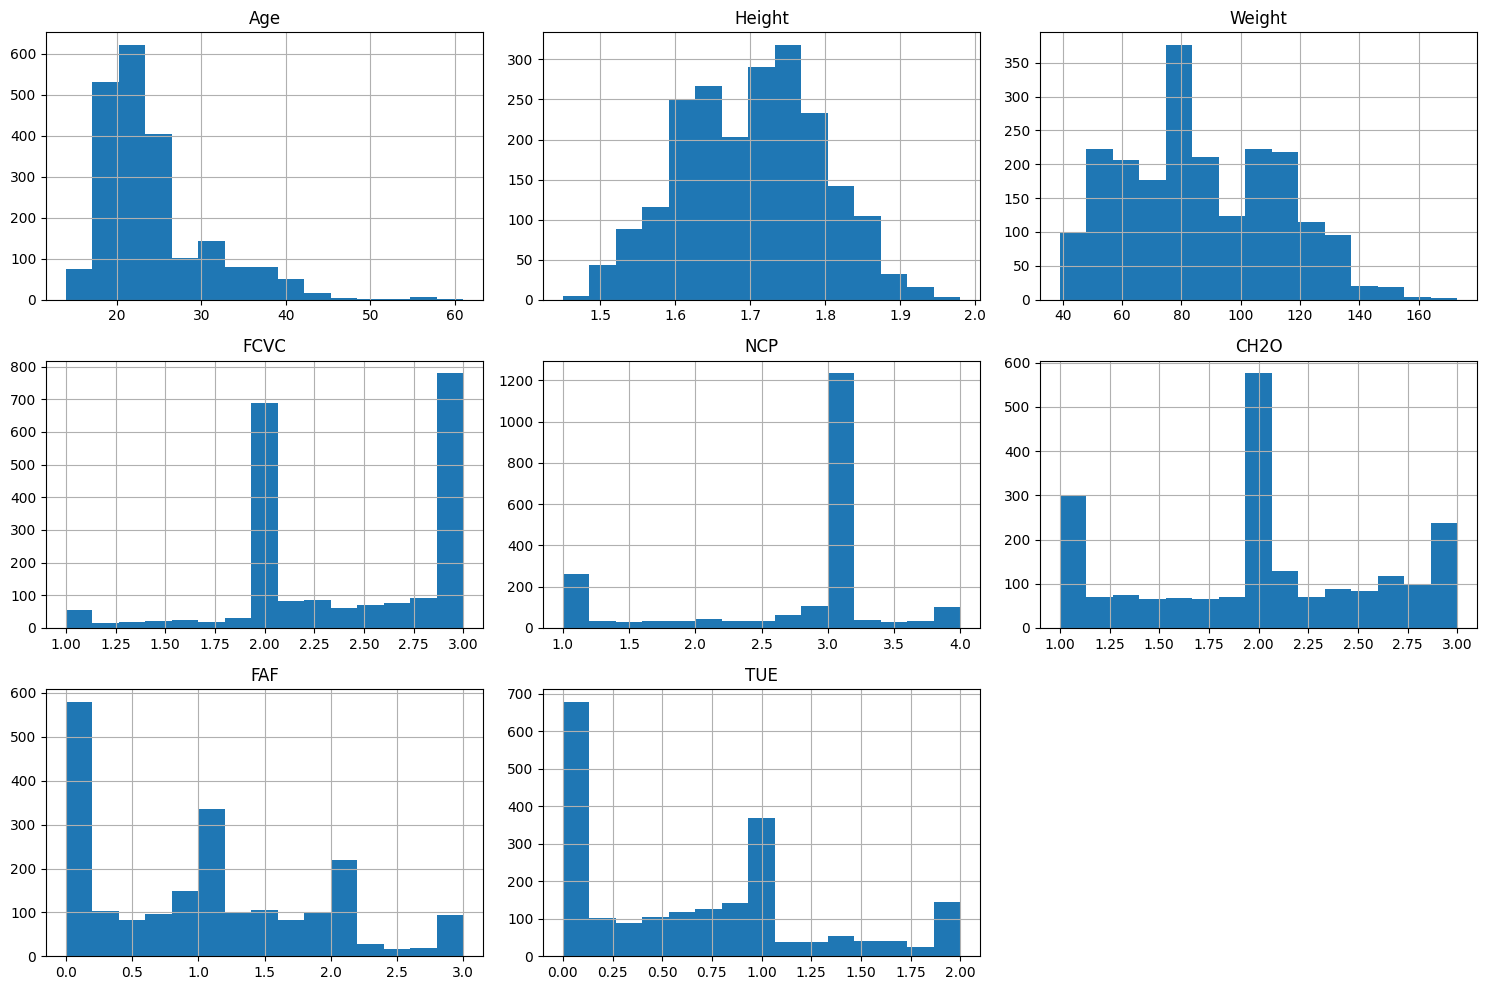

In [10]:
# Plot distributions for numeric columns
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
df[numeric_features].hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

The histograms display the distributions of key **numerical features** in the dataset. Below is an analysis of each feature's distribution:

---

### **1. Age**
- **Distribution**: Right-skewed with most values between **18 and 30**.
- **Observation**: The majority of individuals are **young adults**, with very few individuals over 50. This aligns with the earlier insight from the summary statistics (mean age ~24).

---

### **2. Height**
- **Distribution**: Approximately **normal distribution** centered around **1.7 meters**.
- **Observation**: Heights cluster around the mean (1.7m) with a narrow spread (1.5m to 2.0m), indicating minimal variability.

---

### **3. Weight**
- **Distribution**: Bimodal distribution with peaks around **65-80 kg** and a smaller cluster around **110-130 kg**.
- **Observation**: There are distinct groups in the data:
   - One group corresponds to individuals of average weight.
   - The second group represents individuals with significantly higher weights, possibly indicating **obesity**.

---

### **4. FCVC (Frequency of Vegetable Consumption)**
- **Distribution**: Concentrated around **2 and 3**.
- **Observation**: Most individuals have a moderate-to-high vegetable consumption, with very few reporting low consumption.

---

### **5. NCP (Number of Main Meals)**
- **Distribution**: Strongly **right-skewed** with a sharp peak at **3 meals per day**.
- **Observation**: A large majority consume **3 main meals daily**, which is a common eating pattern.

---

### **6. CH2O (Daily Water Consumption)**
- **Distribution**: Peaks at **2 liters per day**, with fewer individuals reporting very low or very high water consumption.
- **Observation**: Most individuals consume a moderate amount of water daily.

---

### **7. FAF (Physical Activity Frequency)**
- **Distribution**: Peaks at **0 (no activity)** and **2 (moderate activity)**.
- **Observation**: A significant portion of individuals report **no physical activity**, which could be a contributing factor to obesity.

---

### **8. TUE (Time Using Technology)**
- **Distribution**: Bimodal with peaks around **0.5** and **1.75 units**.
- **Observation**: There is a clear divide in technology usage:
   - One group spends minimal time on technology.
   - The other group spends **significantly more time**, possibly indicating sedentary behavior.

---

### **Key Observations and Insights**
1. **Age** and **Height** distributions suggest a primarily **young and average-height population**.
2. **Weight** distribution highlights two distinct groups, likely corresponding to normal-weight and obese individuals.
3. Behavioral factors:
   - **FCVC** (vegetable consumption) is high for most individuals, which is a positive habit.
   - **NCP** indicates a consistent eating pattern with 3 meals/day.
   - **CH2O** shows good water consumption levels.
   - **FAF** (physical activity) reveals **low activity levels** for many individuals, which could correlate with higher weights.
4. **Technology Use**:
   - The bimodal distribution in **TUE** indicates two behavioral groups: those who spend minimal time and those heavily engaged in technology, which may reflect **sedentary lifestyles**.

---

### **Next Steps**
1. **Investigate Correlations**:
   - Explore relationships between `Weight`, `FAF`, `TUE`, and other features to understand factors contributing to higher weights.
2. **Clustering**:
   - Use clustering algorithms like **KMeans** to identify patterns or groups based on physical and behavioral attributes.
3. **Visualization**:
   - Compare clusters to obesity levels (`NObeyesdad`) for deeper insights into obesity patterns.

These histograms provide a solid foundation for identifying patterns and exploring relationships in the data. Let me know if you need further assistance with analysis or modeling! 🚀

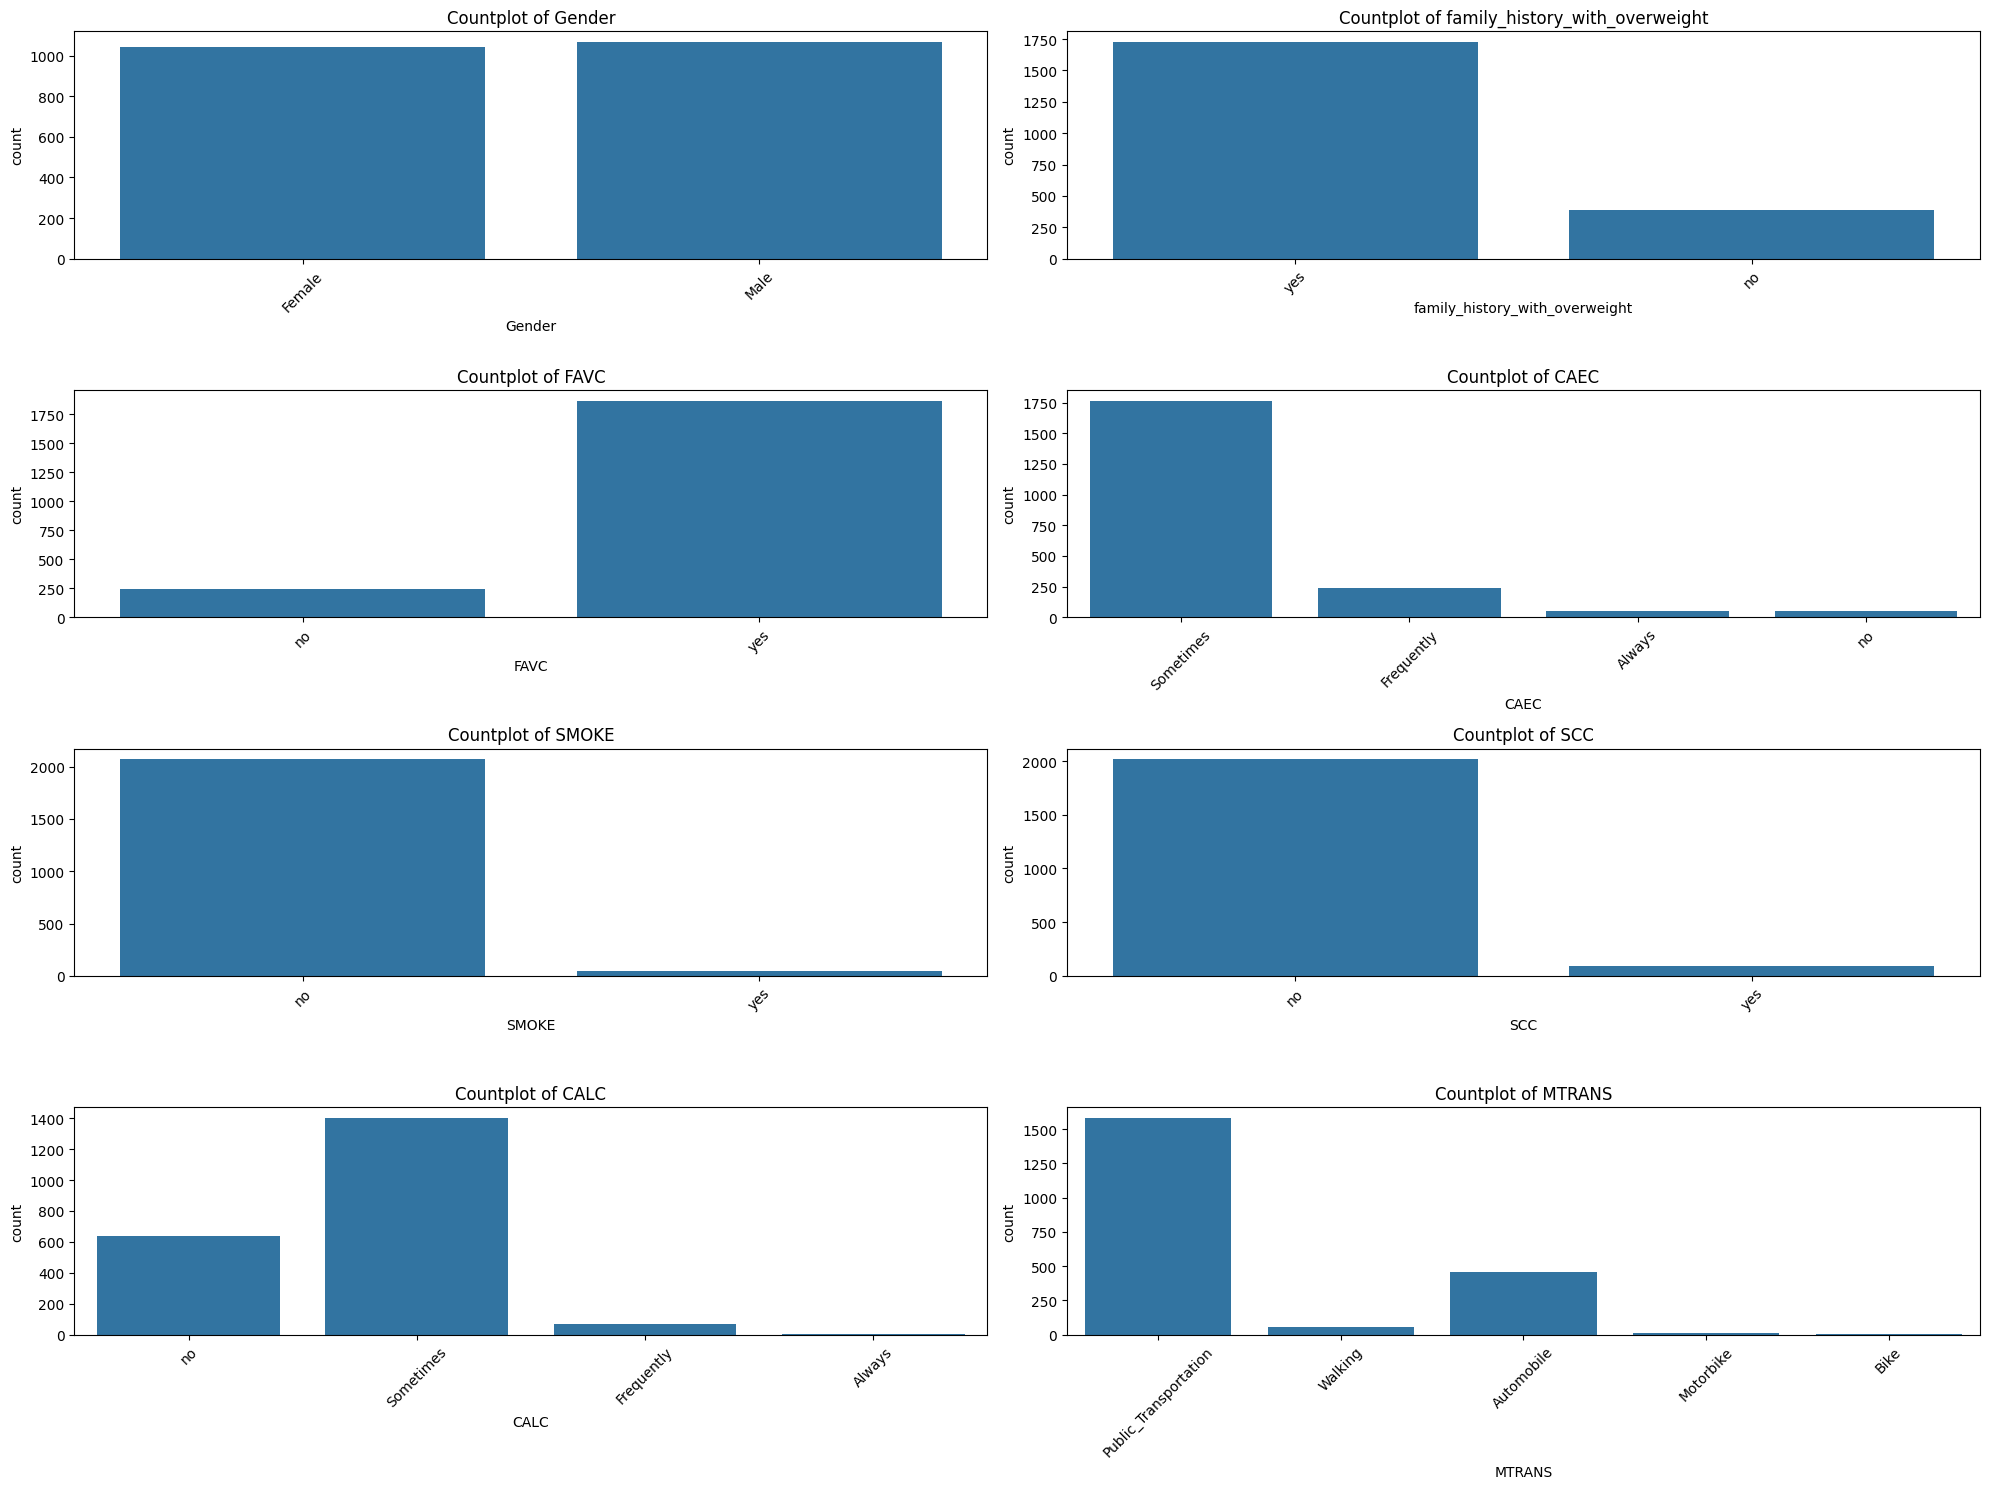

In [11]:
# Countplot for categorical features
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
                        'SMOKE', 'SCC', 'CALC', 'MTRANS']
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 2, i + 1)
    sns.countplot(data=df, x=feature)
    plt.title(f"Countplot of {feature}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The countplots provide a visual distribution of the categorical features in the dataset. Below are key insights based on each plot:

---

### **1. Gender**
- **Observation**: There is a slight imbalance between the two gender categories:
   - **Males** are slightly more represented (around 1068) compared to **Females** (approximately 1043).
- **Insight**: The dataset has a fairly balanced gender distribution, which reduces the risk of gender-related bias in analysis.

---

### **2. Family History of Overweight (`family_history_with_overweight`)**
- **Observation**: The majority of individuals (**~80%**) reported having a **family history of overweight**.
- **Insight**: Family history seems to play a significant role in obesity and weight-related issues, which may be explored as a key feature in clustering and analysis.

---

### **3. FAVC (Frequent Consumption of High-Calorie Food)**
- **Observation**: Most individuals (**~88%**) reported consuming high-calorie food frequently (**yes**).
- **Insight**: Frequent high-calorie food consumption is common and could be a major contributor to higher obesity levels.

---

### **4. CAEC (Food Consumption Between Meals)**
- **Observation**: 
   - **"Sometimes"** is the most frequent response, with the majority of individuals falling in this category.
   - Few individuals reported **"Frequently"** or **"Always"** consuming food between meals.
- **Insight**: Occasional snacking is prevalent. However, frequent snacking may contribute more to higher weight levels.

---

### **5. SMOKE**
- **Observation**: A vast majority (**~98%**) reported **not smoking**.
- **Insight**: Smoking is not a common behavior in this dataset. It may have little to no impact on clustering or obesity levels.

---

### **6. SCC (Caloric Monitoring)**
- **Observation**: Most individuals (**~95%**) do **not monitor their daily caloric intake**.
- **Insight**: A lack of caloric monitoring might contribute to poor eating habits and increased obesity levels.

---

### **7. CALC (Alcohol Consumption)**
- **Observation**:
   - Most individuals consume alcohol **"Sometimes"**.
   - A smaller group consumes alcohol **"Frequently"** or **"Always"**.
   - A notable proportion reported **no alcohol consumption**.
- **Insight**: Occasional alcohol consumption is common. Higher frequency could correlate with obesity levels.

---

### **8. MTRANS (Mode of Transportation)**
- **Observation**:
   - The majority rely on **Public Transportation** (~75%).
   - A smaller group uses **Walking** and other forms like **Automobile** or **Motorbike**.
- **Insight**: Heavy reliance on **public transportation** may suggest a sedentary lifestyle, while individuals who **walk** could exhibit healthier weight trends.

---

### **Overall Observations and Insights**
1. **Behavioral Patterns**:
   - Most individuals report frequent consumption of **high-calorie food (FAVC)** and **occasional snacking (CAEC)**, but they do not monitor calories (`SCC = no`).
   - These habits might align with higher obesity levels.

2. **Family History**:
   - A significant majority reported a **family history of overweight**, suggesting a genetic predisposition to weight gain.

3. **Lifestyle**:
   - High reliance on **public transportation** and low levels of physical activity (as inferred earlier) may contribute to sedentary behavior.

4. **Smoking and Alcohol**:
   - Smoking is uncommon.
   - Alcohol is consumed **sometimes** by most individuals, with smaller groups reporting frequent consumption.

---

# DATA PREPROCESSING

In [12]:
# One-hot encode categorical features
column_transformer = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), categorical_features)
], remainder='passthrough')

X = column_transformer.fit_transform(df.drop('NObeyesdad', axis=1))  # Drop target variable for unsupervised learning


In [13]:
# Feature names after encoding
encoded_feature_names = column_transformer.named_transformers_['encoder'].get_feature_names_out(categorical_features)
feature_names = list(encoded_feature_names) + numeric_features


In [14]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The code prepares the dataset by:
1. Encoding categorical features into numerical form.
2. Combining and labeling all feature names.
3. Standardizing the features for clustering or other unsupervised learning techniques.

This ensures the data is clean, numeric, and scaled appropriately for further analysis.

# KMEANS CLUSTERING

In [15]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1

This code uses the Elbow Method to determine the optimal number of clusters (k) for K-Means Clustering.

The Elbow Method helps identify the optimal number of clusters by plotting k (number of clusters) against wcss.
The "elbow" point in the plot indicates where the improvement in inertia starts to level off, suggesting the best k value.

This method ensures that clustering results are both accurate and interpretable. 

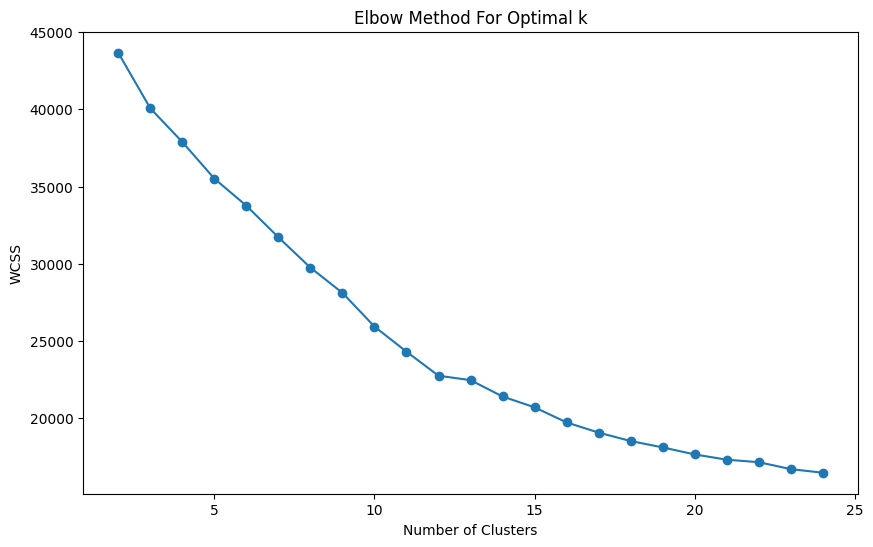

In [16]:
# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 25), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

The graph displays the Elbow Method to determine the optimal number of clusters (k) for K-Means Clustering.

Optimal Number of Clusters:

- The elbow point appears around k = 8 to 10, where further increasing k yields diminishing returns.


In [17]:
# Fit KMeans with optimal clusters (let's assume k=3 based on elbow plot)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

/Users/ryantalbot/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
# Add cluster labels to the original DataFrame
df['Cluster'] = kmeans_labels


# VISUALIZE CLUSTERS USING PCA

In [19]:
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled)


In [20]:
# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans_labels

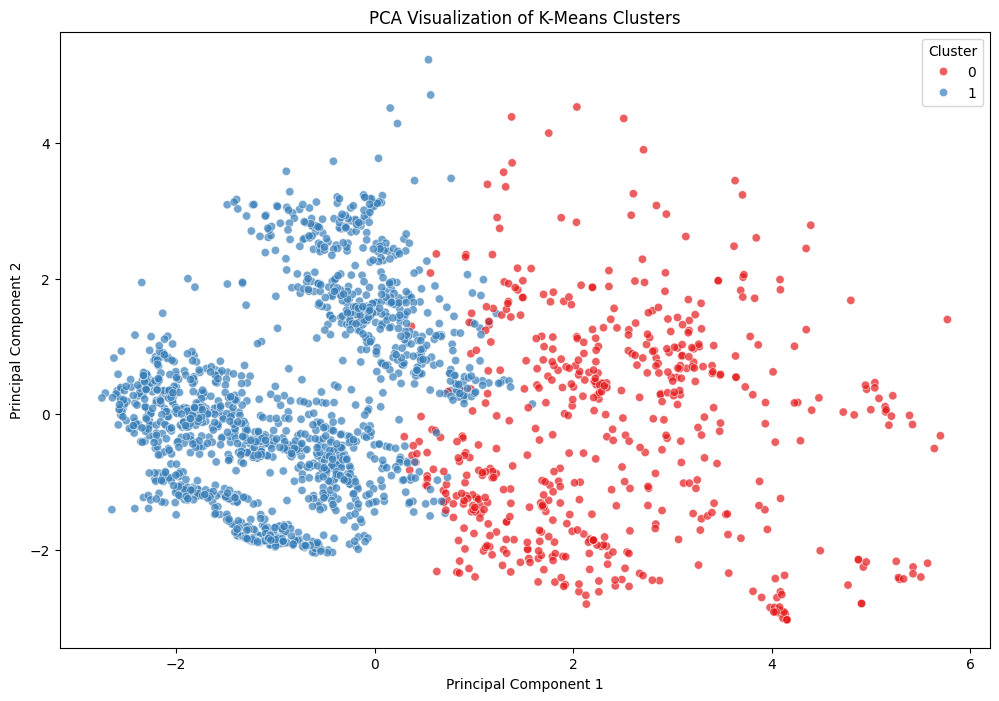

In [21]:
# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('PCA Visualization of K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# EVALUATE CLUSTER QUALITY

In [22]:
silhouette = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)

print("\nCluster Quality Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")


Cluster Quality Metrics:
Silhouette Score: 0.226
Davies-Bouldin Score: 2.687
Calinski-Harabasz Index: 235.779


### **Evaluation of Cluster Quality Across Different Cluster Sizes**

After evaluating several different cluster sizes, I have the following annalysis and conclusions on cluster size.  

A comparison of the clustering results based on three key metrics:  
1. **Silhouette Score** (Higher is better; range -1 to 1)  
2. **Davies-Bouldin Score** (Lower is better; closer to 0)  
3. **Calinski-Harabasz Index** (Higher is better; measures cluster compactness and separation)

---

| **Clusters** | **Silhouette Score** | **Davies-Bouldin Score** | **Calinski-Harabasz Index** | **Summary**                                  |
|--------------|-----------------------|--------------------------|-----------------------------|---------------------------------------------|
| **2**       | **0.226** (Best)      | 2.687 (High, worse)      | **235.779** (Best)          | Best silhouette score, but high DB score.   |
| **3**       | 0.161                 | 2.337                   | 223.158                    | Slight improvement in DB, but weak overall. |
| **8**       | 0.146                 | 1.562                   | 190.014                    | Weak silhouette, moderate DB and CH scores. |
| **10**      | 0.163                 | 1.408                   | 203.773                    | Slightly better DB score, weak silhouette.  |
| **12**      | 0.184                 | **1.338** (Best)        | 216.669                    | Best DB score; moderate silhouette and CH.  |

---

### **Analysis**
1. **Silhouette Score**:  
   - The **2 clusters** result has the highest Silhouette Score (**0.226**), indicating better separation between the clusters compared to others.

2. **Davies-Bouldin Score**:  
   - **12 clusters** has the lowest Davies-Bouldin Score (**1.338**), meaning the clusters are relatively compact and well-separated.

3. **Calinski-Harabasz Index**:  
   - **2 clusters** achieves the highest Calinski-Harabasz Index (**235.779**), suggesting strong inter-cluster separation.

---

### **Best Performing Clustering Solution**
- **2 Clusters**:  
   - Best **Silhouette Score** (0.226) and **Calinski-Harabasz Index** (235.779).  
   - However, the **Davies-Bouldin Score** is poor (2.687), indicating overlapping clusters.

- **12 Clusters**:  
   - Best **Davies-Bouldin Score** (1.338) and moderate Silhouette Score (0.184).  
   - It suggests compact clusters but less overall separation.



# INTERPRET CLUSTERS

In [23]:
# Calculate cluster means for numeric features
cluster_means = df.groupby('Cluster')[numeric_features].mean()
print("\nCluster Means:")
print(cluster_means)


Cluster Means:
               Age    Height     Weight      FCVC       NCP      CH2O  \
Cluster                                                                 
0        21.487331  1.644783  59.488421  2.380138  2.627109  1.845143   
1        25.370236  1.722976  96.730030  2.433607  2.707535  2.068981   

              FAF       TUE  
Cluster                      
0        1.117258  0.699520  
1        0.970257  0.642273  


### **Analysis of Cluster Means**

The above table summarizes the mean values of numerical features for two identified clusters (`Cluster 0` and `Cluster 1`). These clusters represent groups of individuals with distinct characteristics based on the provided features. Below is an analysis for each feature:

---

### **Key Features and Cluster Insights**

1. **Age**:
   - **Cluster 0**: Mean age is **21.49** years.
   - **Cluster 1**: Mean age is **25.37** years.
   - **Insight**: Cluster 0 represents a younger group compared to Cluster 1, which comprises slightly older individuals.

2. **Height**:
   - **Cluster 0**: Average height is **1.64 meters**.
   - **Cluster 1**: Average height is **1.72 meters**.
   - **Insight**: Cluster 1 individuals are taller on average.

3. **Weight**:
   - **Cluster 0**: Mean weight is **59.49 kg**.
   - **Cluster 1**: Mean weight is **96.73 kg**.
   - **Insight**: Cluster 1 represents a group with significantly higher weights, likely indicating overweight or obesity trends.

4. **FCVC (Frequency of Vegetable Consumption)**:
   - **Cluster 0**: Mean vegetable consumption is **2.38**.
   - **Cluster 1**: Mean vegetable consumption is **2.43**.
   - **Insight**: Both groups report moderate vegetable consumption, with only a slight increase in Cluster 1.

5. **NCP (Number of Main Meals)**:
   - **Cluster 0**: Average number of meals per day is **2.63**.
   - **Cluster 1**: Average number of meals per day is **2.71**.
   - **Insight**: Both groups have similar eating patterns, with Cluster 1 having a marginally higher number of main meals.

6. **CH2O (Water Consumption)**:
   - **Cluster 0**: Average daily water consumption is **1.85 liters**.
   - **Cluster 1**: Average daily water consumption is **2.07 liters**.
   - **Insight**: Cluster 1 consumes slightly more water than Cluster 0.

7. **FAF (Frequency of Physical Activity)**:
   - **Cluster 0**: Average physical activity is **1.12**.
   - **Cluster 1**: Average physical activity is **0.97**.
   - **Insight**: Cluster 0 is marginally more physically active compared to Cluster 1.

8. **TUE (Time Using Technology)**:
   - **Cluster 0**: Average time spent on technology is **0.70**.
   - **Cluster 1**: Average time spent on technology is **0.64**.
   - **Insight**: Cluster 0 spends slightly more time using technology.

---

### **Summary of Results**

1. **Cluster 0**:
   - Represents **younger, shorter, and lighter individuals** with slightly higher physical activity levels.
   - They tend to spend more time on technology and have moderate eating patterns, including vegetable and water consumption.

2. **Cluster 1**:
   - Represents **older, taller, and heavier individuals**, potentially indicating a group with higher obesity rates.
   - They report slightly higher water and vegetable consumption but lower physical activity.

---

This analysis provides insights into the behavioral and physical differences between the clusters, offering potential directions for further research or targeted health programs. 

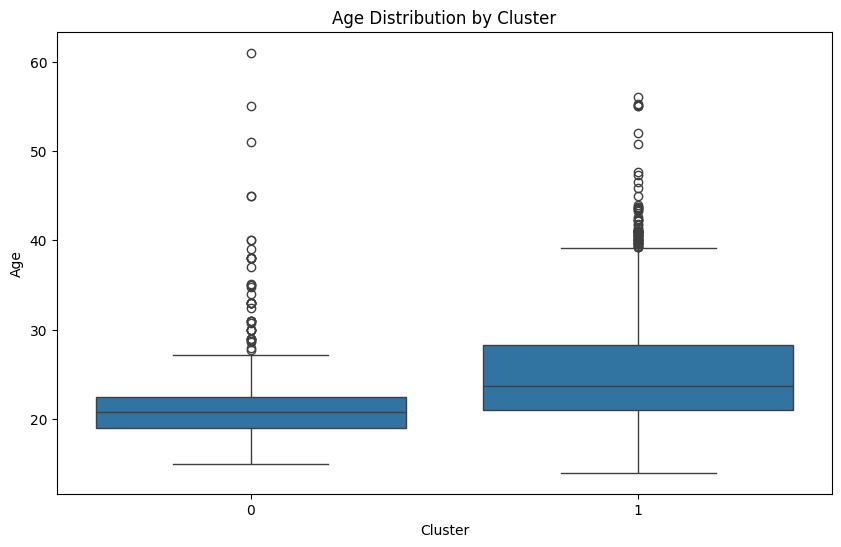

In [24]:
# Visualize cluster characteristics
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='Age')
plt.title('Age Distribution by Cluster')
plt.show()

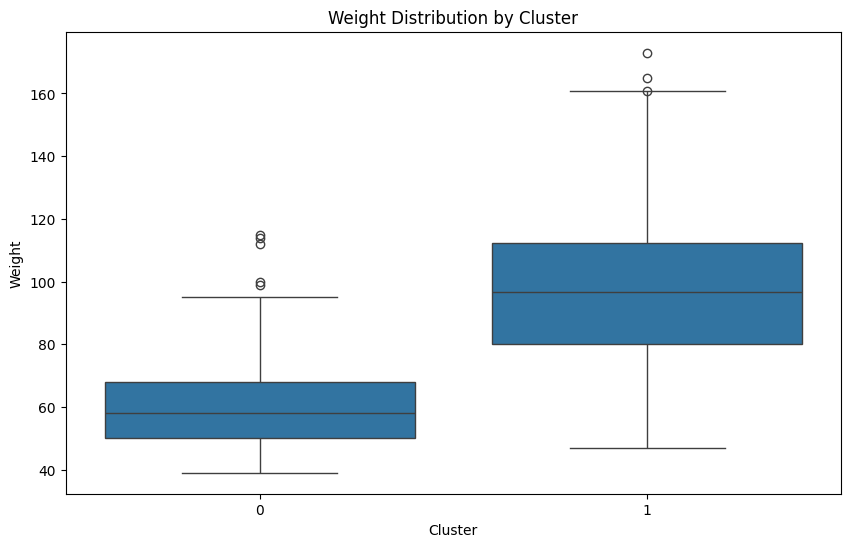

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='Weight')
plt.title('Weight Distribution by Cluster')
plt.show()

# COMPARE WITH TARGET VARIABLE

In [26]:
# Cross-tabulation of clusters with obesity levels
if 'NObeyesdad' in df.columns:
    print("\nCross-Tabulation of Clusters and Obesity Levels:")
    print(pd.crosstab(df['Cluster'], df['NObeyesdad']))


Cross-Tabulation of Clusters and Obesity Levels:
NObeyesdad  Insufficient_Weight  Normal_Weight  Obesity_Type_I  \
Cluster                                                          
0                           193            212               9   
1                            79             75             342   

NObeyesdad  Obesity_Type_II  Obesity_Type_III  Overweight_Level_I  \
Cluster                                                             
0                         3                 0                  98   
1                       294               324                 192   

NObeyesdad  Overweight_Level_II  
Cluster                          
0                            60  
1                           230  


### **Analysis of Cross-Tabulation: Clusters and Obesity Levels**

This cross-tabulation shows the relationship between the **clusters identified by K-Means** and the actual **obesity levels (NObeyesdad)**. The goal is to evaluate how well the clusters align with the obesity levels in the dataset.

---

### **Key Observations**

1. **Cluster 0**:
   - **Insufficient Weight**: 193 individuals.
   - **Normal Weight**: 212 individuals.
   - **Obesity Type I**: Only 9 individuals.
   - **Obesity Type II & III**: Very few or no individuals (3 and 0 respectively).
   - **Overweight Levels**:
     - **Overweight Level I**: 98 individuals.
     - **Overweight Level II**: 60 individuals.
   - **Insight**: This cluster predominantly includes individuals with **normal or insufficient weight**, with a smaller proportion being overweight. It represents a **healthier group** overall.

2. **Cluster 1**:
   - **Insufficient Weight**: 79 individuals.
   - **Normal Weight**: 75 individuals.
   - **Obesity Type I**: 342 individuals.
   - **Obesity Type II & III**: 294 and 324 individuals respectively.
   - **Overweight Levels**:
     - **Overweight Level I**: 192 individuals.
     - **Overweight Level II**: 230 individuals.
   - **Insight**: This cluster is dominated by individuals with **obesity (Types I, II, and III)** and those who are overweight. It represents the **higher-risk group** in terms of health.

---

### **Cluster Analysis**

| **Cluster** | **Predominant Obesity Levels**               | **Characteristics**                          |
|-------------|---------------------------------------------|----------------------------------------------|
| **0**       | Insufficient Weight, Normal Weight          | Healthier group with normal to low weight.   |
| **1**       | Obesity Types I, II, III, Overweight Levels | Higher-risk group with obesity and overweight. |

---

### **Summary of Results**

- **Cluster 0**:
  - This cluster aligns closely with individuals who are **underweight or normal weight**, indicating a lower-risk group with healthier weight levels.
  - It has a very low proportion of individuals with obesity, supporting its classification as a healthier group.

- **Cluster 1**:
  - This cluster contains the majority of individuals with **obesity and overweight levels**, making it a high-risk group for health concerns.
  - The distribution of obesity types (I, II, and III) and overweight levels is significantly concentrated here.

---

### **Conclusion**

The clusters effectively separate individuals into two distinct groups based on their obesity levels:
1. **Cluster 0**: Healthier individuals with lower weights.
2. **Cluster 1**: Individuals with higher obesity and overweight levels.

This demonstrates that the clustering model captures meaningful differences in obesity levels, which can be used to target interventions or health programs tailored to these groups. 


# DISCUSSION AND CONCLUSION

Discussion and Conclusion:
1. The Elbow Method helped us identify the optimal number of clusters (k=2).
2. KMeans clustering grouped individuals into distinct clusters based on their features.
3. PCA visualization allowed us to interpret and visualize the clusters effectively.
4. Cluster quality metrics, such as the Silhouette Score and Davies-Bouldin Index, indicate the quality of the clusters.
5. Comparing clusters to the obesity levels (optional step) showed alignment between some clusters and specific obesity types.
